#**Importing Necessary Library**#


In [ ]:
import torch
import os
import pickle
import numpy as np
import torch.nn.functional as F

from torch import nn,optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

print("Pytorch Version:",torch.__version__)
print("GPU Avaiable:",torch.cuda.is_available())

device = 'cuda' if torch.cuda.is_available() == True else 'cpu'
print("Setting device to:",device)


Pytorch Version: 1.8.1+cu101
GPU Avaiable: True
Setting device to: cuda


#**Importing Dataset**#

In [ ]:
with open("/content/drive/MyDrive/MinorProject/Dataset/rescaled_numbers_dataset(-1to1).pickle",'rb') as file:
  dataset = pickle.load(file)

#**Discriminator Network**#


In [ ]:
class Discriminator(nn.Module):
  def __init__(self, maps = 16):
    super(Discriminator, self).__init__()

    self.features = nn.Sequential(
        #nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1)
        nn.Conv2d(1, maps, 4, 2, 1),
        nn.LeakyReLU(0.2), # shape -> maps, 64, 64
        
        nn.Conv2d(maps, 2 * maps, 4, 2, 1, bias = False),
        nn.BatchNorm2d(2 * maps),
        nn.LeakyReLU(0.2), # shape -> 2 * maps, 32, 32
        
        nn.Conv2d(2 * maps, 4 * maps, 4, 2, 1, bias = False),
        nn.BatchNorm2d(4 * maps),
        nn.LeakyReLU(0.2), # shape -> 4 * maps, 16, 16
        
        nn.Conv2d(4 * maps, 8 * maps, 4, 2, 1, bias = False),
        nn.BatchNorm2d(8 * maps),
        nn.LeakyReLU(0.2), # shape -> 8 * maps, 8, 8
        
        nn.Conv2d(8 * maps, 16 * maps, 4, 2, 1, bias = False),
        nn.BatchNorm2d(16 * maps),
        nn.LeakyReLU(0.2), # shape -> 16 * maps, 4, 4
    )

    self.outputs = nn.Sequential(
        nn.Conv2d(16 * maps, 1, 2, 1, 0),
        nn.Flatten()
    )


    #create optimizer, using stochastic gradient descent
    self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

    #counter and accumulator for progress
    self.counter = 0
    self.progress = []

  def forward(self, x):
    x = self.features(x)
    return self.outputs(x)
  
  def discriminator_loss(self, outputs, targets):
    return F.binary_cross_entropy_with_logits(outputs, targets)

  def train(self, inputs, targets):
    #calculate the output of the network 
    outputs = self.forward(inputs)
    
    #calculate the loss 
    loss = self.discriminator_loss(outputs, targets)

    #increase the counter of training and accumulate the error in every 10 count
    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      
    # zero gradients, perform a backward pass, update weights
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    

    # Finally, we can add a function plot_progress() to draw a chart of the losses accumulated during training
  def plot_progress(self):

    plt.figure(figsize=(16,8))
    plt.plot(self.progress,label="D-Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.title('Loss Vs Iterations');
    plt.show()

#**Generator Network**#

In [ ]:
class Generator(nn.Module):
  def __init__(self, maps = 16, noise_size = 64):
    super(Generator, self).__init__()

    self.model = nn.Sequential(
        #nn.ConvTranspose2d(channels_noise, features_g * 16, kernel_size=4, stride=1, padding=0)
        nn.ConvTranspose2d(noise_size, 16 * maps, 4, 1, 0, bias = False),
        nn.BatchNorm2d(16 * maps),
        nn.ReLU(), # shape -> 16 * maps, 4, 4

        nn.ConvTranspose2d(16 * maps, 8 * maps, 4, 2, 1, bias = False),
        nn.BatchNorm2d(8 * maps),
        nn.ReLU(), # shape -> 8 * maps, 8, 8

        nn.ConvTranspose2d(8 * maps, 4 * maps, 4, 2, 1, bias = False),
        nn.BatchNorm2d(4 * maps),
        nn.ReLU(), # shape -> 4 * maps, 16, 16

        nn.ConvTranspose2d(4 * maps, 2 * maps, 4, 2, 1, bias = False),
        nn.BatchNorm2d(2 * maps),
        nn.ReLU(), # shape -> 2 * maps, 32, 32

        nn.ConvTranspose2d(2 * maps, 1, 4, 2, 1, bias = False),
        nn.Tanh() # shape -> 1,64,64
        
    )

    #create optimizer, using stochastic gradient descent
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

    #counter and accumulator for progress
    self.counter = 0
    self.progress = []

  def forward(self, z):
    z = z.view(-1, 64, 1, 1)
    return self.model(z)

  def train(self, D, inputs, targets):
    # calculate the output of the network
    g_output = self.forward(inputs)

    # pass onto Discriminator
    d_output = D.forward(g_output)

    # calculate error
    loss = D.discriminator_loss(d_output, targets)
    # increase counter and accumulate error every 10
    self.counter += 1
    if (self.counter % 5 == 0):
      self.progress.append(loss.item())
    

    # zero gradients, perform a backward pass, update weights
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    

#**GAN**#

In [ ]:
class GAN:
  def __init__(self):
    self.D = Discriminator().to(device)
    self.G = Generator().to(device)
    self.image_list = []
  
  # creating a function to generate random noise
  def random_noise(self,size):
    return torch.normal(0, 1, size, device = device)
  
  def train(self):
    # Training Generator and Discriminator
    batch_size = 16
    epochs = 70
    ones = torch.ones(batch_size, 1).to(device)
    zeros = torch.zeros(batch_size, 1).to(device)
    Dataset = DataLoader(dataset, batch_size = batch_size, shuffle = True, drop_last = True)
    for i in range(epochs):
      for i,images in tqdm(enumerate(Dataset),desc = f'Epoch({i + 1}/{epochs}'):
        #Training Discriminator in True
        self.D.train(images.to(device), zeros)

        ##Training Discriminator in False
        #use detach() so gradients in G are not calculated
        self.D.train(self.G.forward(self.random_noise([batch_size, 64])), ones)

        #Training Generator
        self.G.train(self.D, self.random_noise([batch_size,64]), zeros)
        
        #Storing the Generator ouput loop for visualizing in image_list in every 1000 training cycles
        if (i%100 == 0):
          output = self.G.forward(self.random_noise([16, 64]))
          self.image_list.append(output.cpu().detach().numpy())
  
  def visualize_losses(self):
    plt.figure(figsize=(16,8))
    plt.plot(self.D.progress,label="D-Loss")
    plt.plot(self.G.progress,label="G-loss")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.title('Loss Vs Iterations');
    plt.show()

  def visualize_results(self,images_list, size = 6, shape = (4, 4)):
    fig = plt.figure(figsize = (size, size))
    grid = ImageGrid(fig, 111, nrows_ncols = shape, axes_pad = 0.04)
    for ax, image in zip(grid, images_list):
      ax.imshow(image[0],cmap='gray')
      # ax.axis('off')

  def generate(self,random_value):
    image_list = self.G.forward(random_value)
    self.visualize_results(image_list.cpu().detach().numpy())

In [ ]:
model = GAN()
model.train()

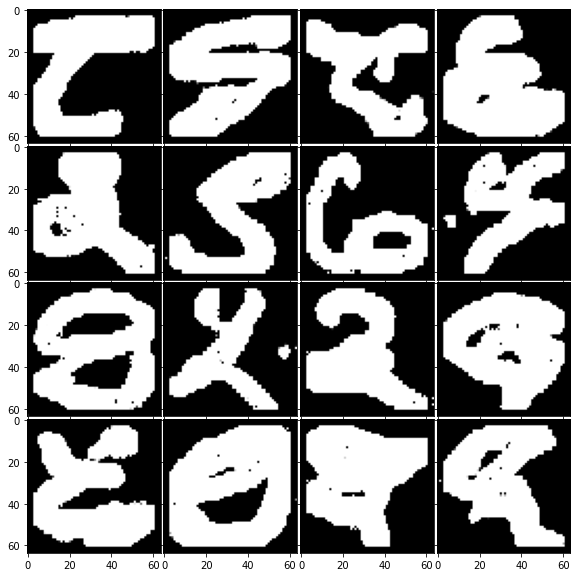

In [ ]:
random_noise = model.random_noise([16,64])
model.generate(random_noise)

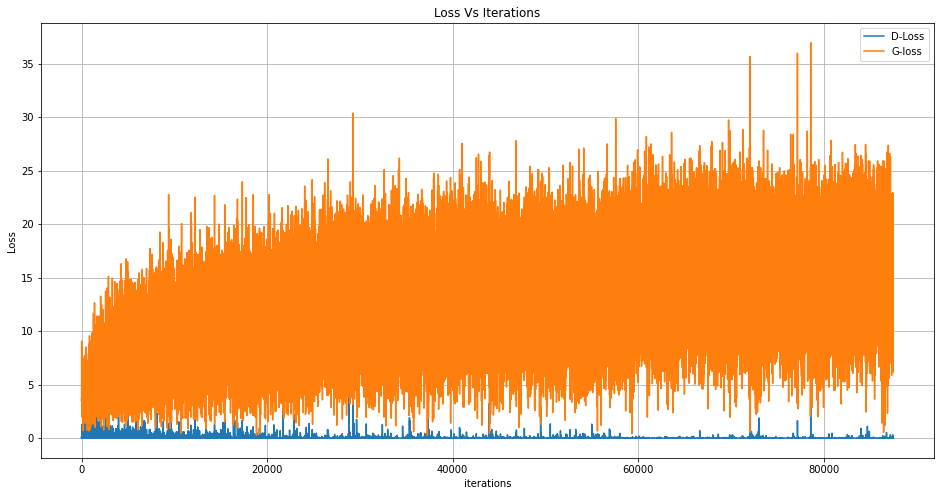

In [ ]:
model.visualize_losses()

In [ ]:
torch.save(model.G.state_dict(), 'nepali_digit_generator.pt')

In [ ]:
model2 = GAN()
model2.G.load_state_dict(torch.load('nepali_digit_generator.pt'))

<All keys matched successfully>

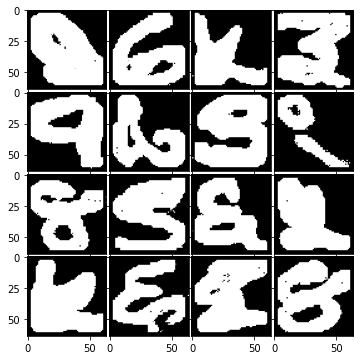

In [ ]:
random_noise = model.random_noise([16,64])
model2.generate(random_noise)